In [1]:
# Run this to allow using the %%R cell magic
%load_ext rpy2.ipython

# Suppress warnings (most notable from rpy2)
import warnings
warnings.filterwarnings('ignore')

# Data Import

In [3]:
%%R
library(SingleCellExperiment)
library(scater)
library(HDF5Array)
# library(FNN)

R[write to console]: Loading required package: rhdf5



In [3]:
%%R
filename <- "./data/Tasic/mouse_ALM_2018-06-14_exon-matrix.csv"
alm <- readSparseCounts(filename,
                        sep = ",",
                        quote = "\"",
                        row.names = TRUE,
                        col.names = FALSE,
                        ignore.row = 1L)
filename <- "./data/Tasic/mouse_VISp_2018-06-14_exon-matrix.csv"
visp <- readSparseCounts(filename,
                         sep = ",",
                         quote = "\"",
                         row.names = TRUE,
                         col.names = FALSE,
                         ignore.row = 1L)
all_counts <- cbind(alm, visp)

In [4]:
%%R
filename <- "./data/Tasic/mouse_ALM_2018-06-14_genes-rows.csv"
rowmeta <- read.csv(filename, stringsAsFactors = FALSE)
rowmeta <- as(rowmeta, "DataFrame")
rownames(rowmeta) <- rowmeta$gene_entrez_id
filename <- "./data/Tasic/mouse_ALM_2018-06-14_samples-columns.csv"
alm_colmeta <- read.csv(filename, stringsAsFactors = FALSE)
alm_colmeta <- alm_colmeta[, c("sample_name", "cluster"), drop = FALSE]
alm_colmeta <- as(alm_colmeta, "DataFrame")
rownames(alm_colmeta) <- alm_colmeta$sample_name
filename <- "./data/Tasic/mouse_VISp_2018-06-14_samples-columns.csv"
visp_colmeta <- read.csv(filename, stringsAsFactors = FALSE)
visp_colmeta <- visp_colmeta[, c("sample_name", "cluster"), drop = FALSE]
visp_colmeta <- as(visp_colmeta, "DataFrame")
rownames(visp_colmeta) <- visp_colmeta$sample_name
colmeta <- rbind(alm_colmeta, visp_colmeta)

In [5]:
%%R
dimnames(all_counts) <- list(rownames(rowmeta), rownames(colmeta))

## Create a SingleCellExperiment class

The CPM normalized counts were used instead of the raw counts.

In [6]:
%%R
sce <- SingleCellExperiment(assays = list(counts = calculateCPM(all_counts)),
                            colData = colmeta,
                            rowData = rowmeta)
# Downsample to 23822 cells
# sce <- sce[, sample(seq_len(ncol(sce)), 23822, replace = FALSE)]
rm(rowmeta, alm_colmeta, visp_colmeta, colmeta, alm, visp, all_counts)
gc()

            used   (Mb) gc trigger    (Mb)   max used    (Mb)
Ncells   5671985  303.0    9496142   507.2    9496142   507.2
Vcells 329665137 2515.2 1345120578 10262.5 1467117721 11193.3


# Feature Selection

There were several metrics that were calculated in order to assit with feature selection. For each gene, the fraction of near-zero counts and mean log2 non-zero expression were computed. For the Tasic data, the threshold was 32. Thus a count less than or equal to 32 was considered to be near-zero and a count greater than 32 was considered to be non-zero. Genes with non-zero expression in fewer than 10 cells were dropped.

In [7]:
%%R
sce

class: SingleCellExperiment 
dim: 45768 23822 
metadata(0):
assays(1): counts
rownames(45768): 71661 76253 ... 100861500 100861503
rowData names(5): gene_symbol gene_id chromosome gene_entrez_id
  gene_name
colnames(23822): F2S4_160420_014_A01 F2S4_160602_005_B01 ...
  F2S4_161010_027_D01 F2S4_160715_004_C01
colData names(2): sample_name cluster
reducedDimNames(0):
spikeNames(0):
altExpNames(0):


In [8]:
%%R
sce <- sce[!(rowSums(counts(sce)) == 0), !(colSums(counts(sce)) == 0)]

In [9]:
%%R
#rowData(sce)$zero_rate <- (rowSums(counts(sce) <= 32)) / ncol(sce)
#rowData(sce)$mean_expr <- apply(counts(sce), 1, function(x) mean(log2(x[x>32])))

NULL


The strategy behind the feature selection used in the paper is to pick genes that have high dropout rate and high mean counts across samples with non-zero counts, the reasoning being that those genes are likely identify cell populations. A line was fit to the remaining genes so that exactly 3000 genes would be selected. The equation of the line was

$$d_{g} > \textrm{exp}[-a(m_{g}-b)]+0.02$$

where $a$ is 1.5, $d_{g}$ is the fraction of near-zero counts, and $m_{g}$ is the mean lg non-zero expression. The $b$ parameter was adjusted so that exactly 3000 genes had a $d_{g}$ satisfying the equation. The parameter $b$ was found with binary search.

In [11]:
%%R
dim(sce)

[1] 42988 23822


In [12]:
%%R
sce <- sce[rowSums(counts(sce) > 32) >= 10, ]
select_genes <- function(sce, n = 3000, threshold = 32, yoffset = 0.02, xoffset = 5, decay = 1.5) {
    
    zero_rate <- (rowSums(counts(sce) <= threshold)) / ncol(sce)
    mean_expr <- apply(counts(sce), 1, function(x) mean(log2(x[x>threshold])))
    up <- 10
    low <- 0
    for (t in seq_len(100)) {
        selected <- zero_rate > (exp(-decay*(mean_expr - xoffset)) + yoffset)
        if (sum(selected) == n) {
            message("Chosen offset: ", round(xoffset, 2))
            break
        } else if (sum(selected) < n) {
            up <- xoffset
            xoffset <- (xoffset + low) / 2
        } else {
            low <- xoffset
            xoffset <- (xoffset + up) / 2 
        }
    }
    rownames(sce)[selected]
}
selected_genes <- select_genes(sce)

R[write to console]: Chosen offset: 6.36



In [13]:
%%R
filtered <- sce[selected_genes, ]
# Free some memory
rm(sce)
gc()

           used  (Mb) gc trigger    (Mb)   max used    (Mb)
Ncells  5594497 298.8    9496142   507.2    9496142   507.2
Vcells 30074694 229.5 2314159405 17655.7 2892697948 22069.6


The counts were converted with a $log_2(x+1)$ transformation.

In [14]:
%%R
assay(filtered, "logcounts") <- log2(counts(filtered) + 1)

In [15]:
%%R
filtered

class: SingleCellExperiment 
dim: 3000 23822 
metadata(0):
assays(2): counts logcounts
rownames(3000): 68397 76261 ... 320158 52696
rowData names(5): gene_symbol gene_id chromosome gene_entrez_id
  gene_name
colnames(23822): F2S4_160420_014_A01 F2S4_160602_005_B01 ...
  F2S4_161010_027_D01 F2S4_160715_004_C01
colData names(2): sample_name cluster
reducedDimNames(0):
spikeNames(0):
altExpNames(0):


# Dimensionality Reduction

## MDS

MDS was computed on the means of the count vectors of the each of the clusters, as given in the cell metadata.

In [16]:
%%R
df <- colData(filtered)
clusters <- as.factor(df$cluster)

In [17]:
%%R
cluster_means <- sapply(levels(clusters),
                        function(x) rowMeans(logcounts(filtered)[, clusters == x]))

In [18]:
%%R
table(clusters)

clusters
                      Astro Aqp4 Batch Grouping VISp L5 PT Chrna6 
                             550                               21 
 Batch Grouping VISp L5 PT Ctxn3                          CR Lhx5 
                             105                               18 
           Doublet Astro Aqp4 Ex          Doublet Endo and Peri_1 
                              14                               32 
           Doublet Endo Peri SMC    Doublet SMC and Glutamatergic 
                               5                                6 
    Doublet VISp L5 NP and L6 CT                      Endo Ctla2a 
                              40                              174 
                      Endo Cytl1      High Intronic VISp L5 Endou 
                               6                              174 
          L2/3 IT ALM Macc1 Lrg1                 L2/3 IT ALM Ptrf 
                             108                               66 
                 L2/3 IT ALM Sla             L2/3 IT 

In [19]:
%%R
mds <- calculateMDS(cluster_means, ntop = nrow(cluster_means))

In [20]:
%%R
mds <- as.data.frame(mds)
mds$n <- as.integer(table(clusters))
mds$cluster <- rownames(mds)

In [21]:
%%R
head(mds)

                                        V1         V2   n
Astro Aqp4                        98.65594  -4.735236 550
Batch Grouping VISp L5 PT Chrna6 -21.98377 -20.988009  21
Batch Grouping VISp L5 PT Ctxn3  -24.71612 -27.977544 105
CR Lhx5                           37.12142   5.232953  18
Doublet Astro Aqp4 Ex             81.62487  -7.066674  14
Doublet Endo and Peri_1          127.53968 -25.040948  32
                                                          cluster
Astro Aqp4                                             Astro Aqp4
Batch Grouping VISp L5 PT Chrna6 Batch Grouping VISp L5 PT Chrna6
Batch Grouping VISp L5 PT Ctxn3   Batch Grouping VISp L5 PT Ctxn3
CR Lhx5                                                   CR Lhx5
Doublet Astro Aqp4 Ex                       Doublet Astro Aqp4 Ex
Doublet Endo and Peri_1                   Doublet Endo and Peri_1


In [7]:
%%R
cluster_colors <- read.csv("./data/Tasic/sample_heatmap_plot_data.csv",
                           stringsAsFactors = FALSE)
cluster_colors <- cluster_colors[, c("cluster_label", "cluster_color")]
cluster_colors <- unique(cluster_colors)
head(cluster_colors)

       cluster_label cluster_color
1  L5 PT ALM Slco2a1       #53D385
2      L5 IT ALM Npw       #33A9CE
3 Lamp5 Fam19a1 Pax6       #FF88AD
4       Sncg Slc17a8       #9440F3
7        Lamp5 Krt73       #DDACC9
8     Sncg Vip Itih5       #6C00BF


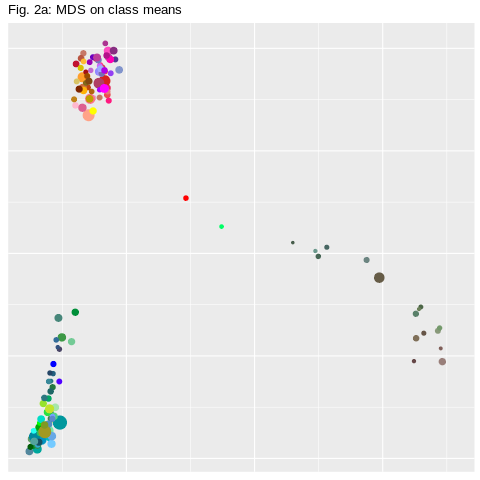

In [23]:
%%R
ggplot(data = mds) +
geom_point(mapping = aes(x = V1, y = V2, size = n, color = cluster)) +
scale_color_manual(values = cluster_colors$cluster_color,
                   breaks = cluster_colors$cluster_label,
                   limits = cluster_colors$cluster_label) +
theme(legend.position = "none", axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank(), axis.text.x = element_blank(),
      axis.text.y = element_blank()) +
xlab(NULL) +
ylab(NULL) +
ggtitle("Fig. 2a: MDS on class means")

In [24]:
%%R
ggsave("tasic_mds.png", width=5, height=5)

In [25]:
%%R
filtered <- runPCA(filtered, ncomponents = 50, ntop = nrow(filtered))

In [26]:
%%R
pca_df <- reducedDim(filtered,"PCA")
pca_df$cluster <- colData(filtered)$cluster

In [5]:
%%R
df <- data.frame("PC1" = reducedDim(filtered, "PCA")[, 1],
                 "PC2" = reducedDim(filtered, "PCA")[, 2],
                 "cluster" = colData(filtered)$cluster)
df$PC1 <- df$PC1 * -1

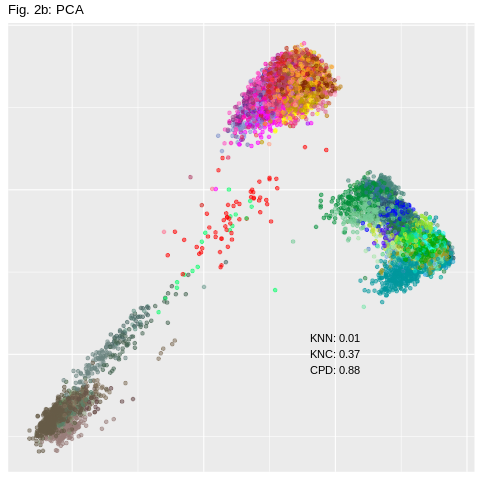

In [13]:
%%R
ggplot(data = df) +
geom_point(mapping = aes(x = PC1, y = PC2, color = cluster, alpha = 0.5)) +
scale_color_manual(values = cluster_colors$cluster_color,
                   breaks = cluster_colors$cluster_label,
                   limits = cluster_colors$cluster_label) +
theme(legend.position = "none", axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank(), axis.text.x = element_blank(),
      axis.text.y = element_blank()) +
annotate("text", x = 0, y = -50, label = "KNN: 0.01\nKNC: 0.37\nCPD: 0.88") +
xlab(NULL) +
ylab(NULL) +
ggtitle("Fig. 2b: PCA")

In [14]:
%%R
ggsave("tasic_pca_labeled.png", width=5, height=5)

In [29]:
%%R
source("~/builds/FIt-SNE/fast_tsne.R", chdir=T)

pca_init <- as.matrix(df[, c("PC1", "PC2")])
pca_init <- pca_init / sd(pca_init[, "PC1"]) * 0.0001
X <- as.matrix(t(logcounts(filtered)))

reducedDim(filtered, "TSNE") <- fftRtsne(reducedDim(filtered, "PCA"),
                                         perplexity_list=c(30, as.integer(ncol(filtered)/100)),
                                         initialization=pca_init,
                                         learning_rate = ncol(filtered) / 12)

R[write to console]: FIt-SNE R wrapper loading.

R[write to console]: FIt-SNE root directory was set to /home/jjl148/builds/FIt-SNE



In [15]:
%%R
df <- data.frame("TSNE1" = reducedDim(filtered, "TSNE")[, 1],
                 "TSNE2" = reducedDim(filtered, "TSNE")[, 2],
                 "cluster" = colData(filtered)$cluster)

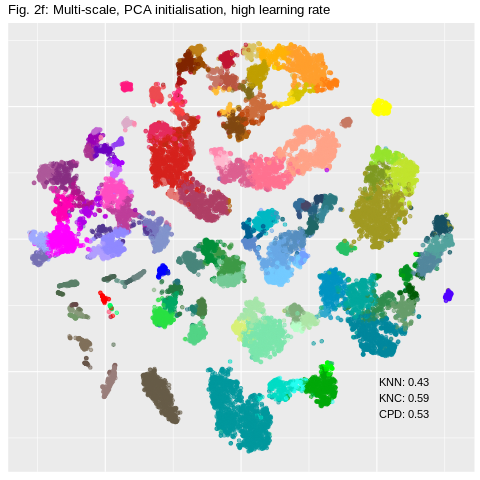

In [19]:
%%R
ggplot(data = df) +
geom_point(mapping = aes(x = TSNE1, y = TSNE2, color = cluster, alpha = 0.1)) +
scale_color_manual(values = cluster_colors$cluster_color,
                   breaks = cluster_colors$cluster_label,
                   limits = cluster_colors$cluster_label) +
theme(legend.position = "none", axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank(), axis.text.x = element_blank(),
      axis.text.y = element_blank()) +
annotate("text", x = 60, y = -60, label = "KNN: 0.43\nKNC: 0.59\nCPD: 0.53") +
xlab(NULL) +
ylab(NULL) +
ggtitle("Fig. 2f: Multi-scale, PCA initialisation, high learning rate")

In [20]:
%%R
ggsave("tasic_tsne_labeled.png", height=5, width=5)

## Save SingleCellExperiment to Disk

In [39]:
%%R

saveHDF5SummarizedExperiment(filtered, replace=TRUE)

R[write to console]: Loading required package: rhdf5



# Embedding Quality

There are three metrics that the paper used to quantify the quality of an embedding.

KNN computes the fraction of k-nearest neighbours in the original high-dimensional data that are preserved as k-nearest neighbours in the embedding. I quantifies the preservation of local structures. k = 10

KNC computes the fraction of k-nearest class means in the original data that are preserved as k-nearest class means in the embedding. k = 10

CPD computes the Spearman correlation between pairwise distances in the high-dimensional space and in the embedding. It is computed across all 499,500 pairs among 1000 randomly chosen points. CPD quantifies preservation of the global structure.

In [4]:
%%R
filtered <- loadHDF5SummarizedExperiment(dir="my_h5_se")

In [184]:
%%R
filtered

class: SingleCellExperiment 
dim: 3000 25481 
metadata(0):
assays(2): counts logcounts
rownames(3000): 68397 76261 ... 320158 52696
rowData names(5): gene_symbol gene_id chromosome gene_entrez_id
  gene_name
colnames(25481): F1S4_161216_001_A01 F1S4_180124_314_A01 ...
  FYS4_171004_104_G01 FYS4_171004_104_H01
colData names(2): sample_name cluster
reducedDimNames(2): PCA TSNE
spikeNames(0):
altExpNames(0):


In [185]:
%%R
tasic_counts <- logcounts(filtered)
rownames(tasic_counts) <- rowData(filtered)$gene_symbol
write.table(tasic_counts, file = "./data/Tasic/tasic_counts.tsv", row.names = TRUE, sep="\t")
write.table(reducedDim(filtered,"PCA"), file = "./data/Tasic/pca.tsv", row.names = FALSE, sep = "\t")
write.table(reducedDim(filtered,"TSNE"), file = "./data/Tasic/tsne.tsv", row.names = FALSE, sep = "\t")
write.table(colData(filtered), file = "./data/Tasic/clusters.tsv", row.names = FALSE, sep = "\t")

In [21]:
import pandas as pd
import numpy as np
from scipy import sparse

In [22]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
import scipy

def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

In [186]:
tasic_counts = pd.read_csv("./data/Tasic/tasic_counts.tsv", sep="\t", header=0, index_col=0)
pca = pd.read_csv("./data/Tasic/pca.tsv", sep="\t")
tsne = pd.read_csv("./data/Tasic/tsne.tsv", sep="\t", header=0, names=['TSNE1', 'TSNE2'])
clusters = pd.read_csv("./data/Tasic/clusters.tsv", sep="\t")

In [187]:
pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,-24.569113,-12.188660,0.291840,-6.912613,6.529056,14.161649,3.783311,11.143745,-6.970758,-4.668292,...,1.807926,3.049541,1.248900,-0.146314,0.793562,-1.123757,-4.955058,0.691978,2.894134,2.787065
1,-37.078387,-20.628412,1.427766,0.423156,-4.669474,-15.354203,3.943614,1.554744,1.762226,-0.947556,...,2.233097,-1.961733,-1.056565,0.971655,1.773984,0.209112,1.361210,-1.214947,0.191755,2.311233
2,19.976944,31.956521,-22.184289,-4.818127,14.630228,-0.019857,12.497639,-4.892088,3.329434,-3.959139,...,-3.030908,-0.850306,2.675932,-1.915002,-1.625908,4.597005,-8.230674,-0.546288,1.215048,5.888783
3,21.224168,24.988138,-18.695190,-2.817919,3.000672,-3.173056,5.231716,6.268002,-0.124884,-2.370093,...,-7.575739,-5.772238,-1.710949,-5.474450,8.630632,-1.522615,-1.883293,2.505342,-9.159466,3.381694
4,21.519865,30.611779,-14.949170,-2.727846,-2.109644,-2.243796,11.715133,3.779421,-2.336611,-3.908030,...,-5.177761,-3.168360,-3.836538,-6.927803,6.587438,1.206788,-0.001642,0.323798,-14.321046,0.625304


In [188]:
pca_array = pca.values

In [189]:
tsne.head()

,TSNE1,TSNE2
0,-17.420035,-39.397101
1,31.236733,-22.824600
2,-39.254120,42.986901
3,-45.917250,35.862117
4,-46.515556,35.620053


In [190]:
tsne_array = tsne.values

In [191]:
clusters.head()

,sample_name,cluster
0,F1S4_161216_001_A01,L5 PT ALM Slco2a1
1,F1S4_180124_314_A01,L5 IT ALM Npw
2,F1S4_180124_315_A01,Lamp5 Fam19a1 Pax6
3,F1S4_180124_315_B01,Sncg Slc17a8
4,F1S4_180124_315_C01,Sncg Slc17a8


In [192]:
tasic_counts.head()

,F1S4_161216_001_A01,F1S4_180124_314_A01,F1S4_180124_315_A01,F1S4_180124_315_B01,F1S4_180124_315_C01,F1S4_180124_315_D01,F1S4_180124_315_E01,F1S4_180124_315_F01,F1S4_180124_315_G01,F1S4_180124_315_H01,...,FYS4_171004_103_G01,FYS4_171004_103_H01,FYS4_171004_104_A01,FYS4_171004_104_B01,FYS4_171004_104_C01,FYS4_171004_104_D01,FYS4_171004_104_E01,FYS4_171004_104_F01,FYS4_171004_104_G01,FYS4_171004_104_H01
0610039H22Rik,0.000000,0.000000,0.000000,0.000000,0.00000,1.109209,0.000000,1.627253,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610040J01Rik,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.342319,0.000000,0.000000,0.000000
1110008P14Rik,8.529680,10.041393,7.249662,7.000739,6.93837,6.651418,6.742475,7.472008,9.534318,9.849694,...,7.453179,9.201716,6.762961,6.649957,8.178001,7.702256,5.633825,8.902912,7.439168,4.493861
1110058D11Rik,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1190005I06Rik,2.605859,0.000000,0.000000,3.766548,0.00000,0.000000,0.000000,3.516798,0.000000,3.905083,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## PCA Embedding Quality

In [66]:
knn, knc, cor = embedding_quality(pca_array, pca_array[:,0:1], (clusters['cluster']).values)

In [67]:
[knn, knc, cor]

[0.00630273537145324, 0.37350993377483444, 0.8800066868845499]

## TSNE Embedding Quality

In [68]:
knn_t, knc_t, cor_t = embedding_quality(pca_array, tsne_array, (clusters['cluster']).values)

In [69]:
[knn_t, knc_t, cor_t]

[0.4300890859856364, 0.5913907284768212, 0.5322605558218902]

# Position New Cells on Existing TSNE

In [52]:
import warnings

# Computing the matrix of correlations
def corr2(A,B):
    A = A - A.mean(axis=1, keepdims=True)
    B = B - B.mean(axis=1, keepdims=True)
    ssA = (A**2).sum(axis=1, keepdims=True)
    ssB = (B**2).sum(axis=1, keepdims=True)
    # this ignores the NaN warnings. The result can have nans!
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        C = np.dot(A, B.T) / np.sqrt(np.dot(ssA,ssB.T))
    return C

def map_to_tsne(referenceCounts, referenceGenes, newCounts, newGenes, referenceAtlas, 
                bootstrap = False, knn = 10, nrep = 100, seed = None, batchsize = 1000,
				verbose = 1):
    gg = sorted(list(set(referenceGenes) & set(newGenes)))
    if verbose > 0:
        print('Using a common set of ' + str(len(gg)) + ' genes.')
    
    newGenes = [np.where(newGenes==g)[0][0] for g in gg]
    refGenes = [np.where(referenceGenes==g)[0][0] for g in gg]
    X = newCounts[:,newGenes]
    if sparse.issparse(X):
        X = np.array(X.todense())
    X = np.log2(X + 1)
    T = referenceCounts[:,refGenes]
    if sparse.issparse(T):
        T = np.array(T.todense())
    T = np.log2(T + 1)
    
    n = X.shape[0]
    assignmentPositions = np.zeros((n, referenceAtlas.shape[1]))
    batchCount = int(np.ceil(n/batchsize))
    if (batchCount > 1) and (verbose > 0):
        print('Processing in batches', end='', flush=True) 
    for b in range(batchCount):
        if (batchCount > 1) and (verbose > 0):
            print('.', end='', flush=True) 
        batch = np.arange(b*batchsize, np.minimum((b+1)*batchsize, n))
        C = corr2(X[batch,:], T)
        ind = np.argpartition(C, -knn)[:, -knn:]
        for i in range(batch.size):
            assignmentPositions[batch[i],:] = np.median(referenceAtlas[ind[i,:],:], axis=0)
    if (batchCount > 1) and (verbose > 0):
        print(' done', flush=True) 
    
    # Note: currently bootstrapping does not support batchsize
    if bootstrap:
        if seed is not None:
            np.random.seed(seed)
        assignmentPositions_boot = np.zeros((n, referenceAtlas.shape[1], nrep))
        if verbose>0:
            print('Bootstrapping', end='', flush=True)
        for rep in range(nrep):
            if verbose>0:
                print('.', end='')
            bootgenes = np.random.choice(T.shape[1], T.shape[1], replace=True)
            C_boot = corr2(X[:,bootgenes],T[:,bootgenes])
            ind = np.argpartition(C_boot, -knn)[:, -knn:]
            for i in range(X.shape[0]):
                assignmentPositions_boot[i,:,rep] = np.median(referenceAtlas[ind[i,:],:], axis=0)
        if verbose>0:
            print(' done')      
        return (assignmentPositions, assignmentPositions_boot)
    else:
        return assignmentPositions

Load Cadwell data

In [23]:
data = pd.read_excel('data/Cadwell/Data_CortexInterneurons.xlsx', sheet_name='readcounts')
cells  = np.array([int(c[5:-1]) for c in data.values[2,2:-5]])
genes  = np.array([c[1:-1] for c in data.values[4:,1]])
counts = data.values[4:,2:-5].T.astype('float')

from scipy import io
mat = io.loadmat('data/Cadwell/IntPhysiologyFinal.mat')
types = np.array([mat['cell'][0][n][3][0][0] for n in range(len(mat['cell'][0]))])
idxs  = np.array([mat['cell'][0][n][0][0][0] for n in range(len(mat['cell'][0]))])

# Int_44 and Int_45 were removed from the Cadwell et al. due to possible contamination
types = types[(idxs != 44) & (idxs != 45)]
idxs  =  idxs[(idxs != 44) & (idxs != 45)]
counts = counts[[np.where(cells==i)[0][0] for i in idxs], :]

counts = sparse.csr_matrix(counts)
cadwell2016 = {'counts': counts, 'genes': genes, 'clusters': types}

In [8]:
cadwell2016

{'counts': <46x21812 sparse matrix of type '<class 'numpy.float64'>'
 	with 399613 stored elements in Compressed Sparse Row format>,
 'genes': array(['Adora1', 'Sntg1', 'Prim2', ...,
        'ERCC_0.11444092:mix1_0.22888184:mix2',
        'ERCC_0.05722046:mix1_0.11444092:mix2',
        'ERCC_0.01430512:mix1_0.02861023:mix2'], dtype='<U88'),
 'clusters': array([5, 5, 5, 5, 1, 4, 5, 5, 5, 5, 1, 1, 2, 3, 1, 5, 1, 2, 5, 5, 5, 1,
        5, 4, 2, 1, 1, 1, 1, 5, 1, 5, 5, 2, 3, 4, 5, 2, 5, 1, 5, 5, 5, 1,
        1, 5], dtype=uint8)}

Convert Tasic Data

In [193]:
genes = tasic_counts.index.values.astype('str')
counts = sparse.csr_matrix(tasic_counts.values.T.astype('float'))
tasic2018 = {'counts' : counts, 'genes': genes, 'clusters' : (clusters['cluster']).values}

In [194]:
tasic2018

{'counts': <25481x3000 sparse matrix of type '<class 'numpy.float64'>'
 	with 13777021 stored elements in Compressed Sparse Row format>,
 'genes': array(['0610039H22Rik', '0610040J01Rik', '1110008P14Rik', ..., 'Zic5',
        'Zmat4', 'Zwint'], dtype='<U14'),
 'clusters': array(['L5 PT ALM Slco2a1', 'L5 IT ALM Npw', 'Lamp5 Fam19a1 Pax6', ...,
        'L5 PT VISp Chrna6', 'Sst Calb2 Pdlim5', 'Pvalb Reln Tac1'],
       dtype=object)}

In [53]:
pos, pos_boot = map_to_tsne(tasic2018['counts'],
                            tasic2018['genes'],
                            cadwell2016['counts'], cadwell2016['genes'],
                            tsne_array, bootstrap = True, seed=42, knn=10)

Using a common set of 2451 genes.
Bootstrapping.................................................................................................... done


In [78]:
cadwell_pos = np.append(pos, np.reshape(cadwell2016['clusters'], newshape=[-1, 1]), 1)
cadwell_pos.shape

(46, 3)

In [82]:
np.savetxt("./data/Cadwell/cadwell_on_tasic.csv", cadwell_pos, delimiter="\t")

## Visualize Cadwell Mapped to Tasic Data

In [85]:
%%R
cadwell <- read.table("./data/Cadwell/cadwell_on_tasic.csv", sep="\t", col.names = c("TSNE1", "TSNE2", "cluster"))

In [88]:
%%R
cadwell <- cadwell[cadwell$cluster != 3,]

        TSNE1     TSNE2 cluster
1    2.021530 24.026091       5
2   -8.451322 33.668749       5
3   -6.012594 24.849793       5
4   -7.980090 27.541659       5
5   19.228796 29.857944       1
6    7.631649 22.093645       4
7   -8.093000 30.043382       5
8   -4.664305 27.479930       5
9  -49.363210 34.126827       5
10  -7.378144 27.510484       5
11  20.011201 29.684227       1
12  23.414409 30.915568       1
13   3.929574 27.157752       2
15   2.606946 25.477327       1
16  -8.395152 28.991639       5
17   8.874254 25.582679       1
18   5.683388 26.227618       2
19   3.304149 23.744440       5
20  -8.693255 33.497664       5
21 -31.726045  5.139035       5
22   8.929567 25.103570       1
23  -6.609307 28.231664       5
24   5.054244 24.918313       4
25   7.619132 23.222246       2
26   8.019151 24.557702       1
27   7.960646 26.800674       1
28  20.207511 30.426669       1
29  24.774915 32.709692       1
30   1.290756 26.865694       5
31  11.554236 24.282415       1
32  -7.4

In [67]:
%%R
important_clusters <- grep("Lamp|Vip", colData(filtered)$cluster)
important_clusters

   [1]     3     7     8    12    15    18    20    22   187   188   189   190
  [13]   191   192   193   194   195   196   197   198   199   200   201   202
  [25]   203   204   205   206   207   208   209   210   211   212   213   214
  [37]   215   216   217   218   219   220   221   222   223   224   225   226
  [49]   227   229   230   231   232   233   234   235   236   237   238   239
  [61]   240   241   242   243   244   245   246   247   248   249   250   251
  [73]   252   253   254   255   256   257   258   259   260   261   262   263
  [85]   264   266   267   268   269   270   271   272   273   274   275   276
  [97]   277   278   279   280   281   282   283   284   285   286   287   288
 [109]   289   290   291   292   293   295   296   297   298   299   300   301
 [121]   302   303   304   305   306   307   308   309   310   311   312   313
 [133]   314   315   316   317   318   319   320   321   322   323   324   325
 [145]   326   327   328   329   330   331   332   3

[1237]  3622  3623  3624  3625  3626  3628  3629  3630  3631  3633  3634  3635
[1249]  3636  3639  3640  3641  3642  3644  3646  3651  3654  3657  3658  3660
[1261]  3666  3668  3674  3678  3686  3687  3688  3689  3690  3692  3693  3694
[1273]  3695  3696  3697  3699  3700  3701  3702  3703  3704  3705  3706  3709
[1285]  3710  3711  3712  3713  3714  3715  3716  3717  3718  3719  3720  3721
[1297]  3722  3724  3726  3727  3728  3730  3731  3733  3734  3737  3738  3739
[1309]  3740  3741  3742  3743  3748  3751  3754  3755  3756  3757  3758  3759
[1321]  3761  3762  3763  3766  3767  3769  3770  3771  3772  3773  3774  3775
[1333]  3776  3777  3778  3779  3780  3781  3782  3783  3787  3788  3789  3790
[1345]  3792  3795  3798  3801  3802  3807  3808  3809  3812  3814  3816  3817
[1357]  3818  3819  3821  3822  3823  3824  3825  3827  3828  3829  3830  3831
[1369]  3833  3834  3835  3836  3838  3839  3840  3841  3842  3843  3844  3845
[1381]  3846  3848  3849  3850  3851  3852  3853  38

[2473] 10671 10672 10673 10674 10678 10679 10680 10681 10683 10684 10686 10687
[2485] 10688 10708 10713 10717 10733 10736 10746 10752 10771 10773 10774 10775
[2497] 10776 10777 10781 10801 10805 10817 10818 10819 10820 10821 10822 10823
[2509] 10824 10825 10827 10828 10829 10830 10831 10832 10833 10834 10835 10836
[2521] 10837 10838 10839 10840 10841 10842 10843 10844 10845 10846 10847 10848
[2533] 10849 10850 10851 10852 10853 10855 10857 10858 10859 10860 10861 10862
[2545] 10863 10864 10865 10866 10867 10868 10870 10871 10872 10875 10879 10880
[2557] 10888 10891 10894 10895 10898 10901 10902 10905 10906 10909 10910 10914
[2569] 10921 10922 10925 10926 10927 10928 10929 10930 10931 10932 10933 10934
[2581] 10935 10936 10937 10938 10939 10940 10941 10942 10943 10944 10945 10946
[2593] 10947 10948 10949 10950 10951 10952 10953 10954 10955 10956 10957 10958
[2605] 10959 10960 10966 10968 10976 10983 10992 10999 11057 11058 11060 11061
[2617] 11067 11084 11087 11093 11096 11112 11149 111

[3709] 14853 14854 14855 14856 14857 14858 14859 14860 14861 14862 14863 14864
[3721] 14865 14866 14867 14868 14869 14870 14871 14872 14873 14874 14875 14876
[3733] 14877 14878 14879 14880 14881 14882 14883 14884 14885 14886 14887 14931
[3745] 14940 14946 14949 14950 14952 14954 14955 14956 14959 14960 14961 14964
[3757] 14965 14966 14967 14968 14969 14970 14971 14972 14973 14974 14975 14977
[3769] 14978 14979 14980 14981 14982 14983 14985 14988 14989 14992 14999 15003
[3781] 15007 15008 15009 15011 15019 15020 15024 15026 15036 15040 15043 15046
[3793] 15050 15055 15058 15062 15065 15072 15073 15078 15080 15081 15082 15083
[3805] 15089 15090 15092 15096 15099 15101 15110 15113 15114 15117 15120 15125
[3817] 15126 15128 15130 15133 15135 15136 15141 15143 15144 15145 15146 15147
[3829] 15148 15149 15150 15151 15152 15153 15154 15155 15156 15157 15158 15159
[3841] 15160 15161 15162 15164 15172 15174 15178 15180 15181 15184 15195 15199
[3853] 15203 15213 15218 15234 15242 15244 15249 152

[4945] 23013 23014 23015 23016 23017 23019 23020 23021 23022 23023 23024 23029
[4957] 23138 23139 23140 23141 23143 23144 23145 23146 23147 23148 23149 23150
[4969] 23151 23159 23167 23185 23186 23187 23188 23189 23190 23191 23192 23193
[4981] 23194 23195 23196 23197 23198 23199 23200 23201 23202 23203 23204 23206
[4993] 23207 23209 23210 23211 23212 23213 23214 23215 23216 23217 23218 23219
[5005] 23224 23225 23226 23227 23228 23229 23230 23232 23240 23248 23251 23253
[5017] 23256 23264 23273 23280 23315 23324 23356 23369 23373 23637 23638 23639
[5029] 23641 23642 23644 23645 23647 23648 23649 23651 23652 23653 23654 23655
[5041] 23656 23657 23658 23659 23660 23661 23662 23663 23664 23665 23667 23668
[5053] 23669 23670 23671 23674 23675 23678 23679 23680 23684 23685 23686 23687
[5065] 23688 23689 23690 23691 23692 23693 23694 23695 23696 23697 23698 23700
[5077] 23704 23706 23709 23710 23711 23712 23715 23719 23720 23721 23722 23723
[5089] 23724 23726 23727 23729 23730 23731 23732 237

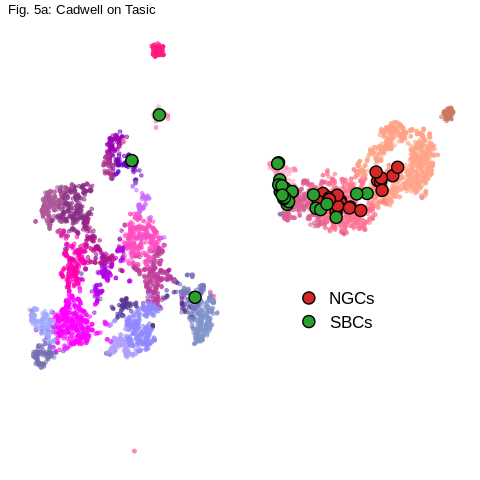

In [207]:
%%R
df <- data.frame("TSNE1" = reducedDim(filtered, "TSNE")[, 1],
                 "TSNE2" = reducedDim(filtered, "TSNE")[, 2],
                 "cluster" = colData(filtered)$cluster)
tasic_subset <-df[important_clusters, ]

ggplot(data = tasic_subset) +
geom_point(mapping = aes(x = TSNE1, y = TSNE2, color = cluster, alpha = 0.1)) +
geom_point(data = cadwell[cadwell$cluster <= 2, ], mapping=aes(x=TSNE1, y=TSNE2), size=5, colour="black", fill="#d62728", shape=21, stroke=1) +
geom_point(data = cadwell[cadwell$cluster >= 4, ], mapping=aes(x=TSNE1, y=TSNE2), size=5, colour="black", fill="#2ca02c", shape=21, stroke=1) +
geom_point(data=data.frame("x"=0,"y"=5), mapping=aes(x=x, y=y), size=5, colour="black", fill="#d62728", shape=21, stroke=1) +
geom_point(data=data.frame("x"=0,"y"=0), mapping=aes(x=x, y=y), size=5, colour="black", fill="#2ca02c", shape=21, stroke=1) +
annotate("text", x = 12, y = 5, size=6, label = "NGCs") +
annotate("text", x = 12, y = 0, size=6, label = "SBCs") +
scale_color_manual(values = cluster_colors$cluster_color,
                   breaks = cluster_colors$cluster_label,
                   limits = cluster_colors$cluster_label) +
theme(legend.position = "none", axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank(), axis.text.x = element_blank(),
      axis.text.y = element_blank(), panel.background = element_rect(fill="white")) +
xlab(NULL) +
ylab(NULL) +
ggtitle("Fig. 5a: Cadwell on Tasic")

In [208]:
%%R
ggsave("cadwell_on_tasic_labeled.png", height=5, width=5)

## Map Tasic to Self

In [195]:
cluster_mask.shape

{'counts': <25481x3000 sparse matrix of type '<class 'numpy.float64'>'
 	with 13777021 stored elements in Compressed Sparse Row format>,
 'genes': array(['0610039H22Rik', '0610040J01Rik', '1110008P14Rik', ..., 'Zic5',
        'Zmat4', 'Zwint'], dtype='<U14'),
 'clusters': array(['L5 PT ALM Slco2a1', 'L5 IT ALM Npw', 'Lamp5 Fam19a1 Pax6', ...,
        'L5 PT VISp Chrna6', 'Sst Calb2 Pdlim5', 'Pvalb Reln Tac1'],
       dtype=object)}

In [179]:
tasic2018['clusters'][vipcells]

array(['Lamp5 Fam19a1 Pax6', 'Lamp5 Krt73', 'Lamp5 Lsp1', ...,
       'Vip Igfbp4 Mab21l1', 'Vip Ptprt Pkp2', 'Lamp5 Lsp1'], dtype=object)

In [196]:
cluster_mask.shape

(25481,)

In [158]:
import re
r = re.compile('Lamp|Vip')
cluster_mask = np.array([bool(r.match(c)) for c in tasic2018['clusters']])

vipcells = np.where(cluster_mask)[0]
np.random.seed(42)
vipcells_sample = vipcells[np.random.choice(vipcells.shape[0], size=100, replace=False)]
vipcells_sample_pos = np.zeros((vipcells_sample.shape[0],2))

for i,v in enumerate(vipcells_sample):
    print('.', end='', flush=True)
    notv = np.arange(tasic2018['counts'].shape[0]) != v
    vipcells_sample_pos[i,:] = map_to_tsne(
        tasic2018['counts'][notv,:],
        tasic2018['genes'],
        tasic2018['counts'][v,:],
        tasic2018['genes'], 
        tsne_array[notv,:], knn=10, verbose=0)

....................................................................................................

In [172]:
vipcells_sample

array([15386,  4707,  5631,  3522, 18594, 15088, 13183,  3808,  3960,
       18672,  1251,   773, 13052, 24794,  5612, 15406, 15450, 14844,
        3031, 14969,   211, 20603, 16356, 14236, 19057,  3855,  1018,
       18867,  1719,  2111,  1994, 15311,  6591, 12998,  5647,  6514,
       15263, 14187,  6584,  5727, 14998,   205,   250, 10965,  3900,
        4624,  4514, 11949,   994,  4557, 15072, 10424,  4024, 15127,
        1010,   376,  2071,  4732,  3476,  3534, 23009, 11436,   270,
        3974,  2952, 20071, 11473, 23198, 18592, 15379, 11588, 16221,
       12255,  3474,  1923,  2998,  8904, 14613, 15373,  1710,  3053,
       14438,  5150, 20130, 15275, 11307, 13178, 14879, 11876,  4863,
        1812,  3903, 12085,  3261, 12655, 20652,  5619, 24532, 22728,
       15716])

In [162]:
tasic_on_tasic = np.append(np.reshape(vipcells_sample, newshape=[-1, 1]), vipcells_sample_pos, 1)
np.savetxt("./data/Tasic/tasic_on_tasic.csv", tasic_on_tasic, delimiter="\t")

## Visualize Tasic Mapping to Self

In [173]:
%%R
tasic_on_tasic <- read.table("./data/Tasic/tasic_on_tasic.csv", sep="\t", col.names = c("cell_num", "TSNE1_new", "TSNE2_new"))
head(tasic_on_tasic)

  cell_num  TSNE1_new TSNE2_new
1    15386   6.705964 27.542918
2     4707 -59.656096 29.002261
3     5631 -32.243606  5.256586
4     3522  18.063712 28.462765
5    18594 -67.278270  2.409587
6    15088 -29.924982  6.703433


In [178]:
%%R
tail(colData(filtered))

DataFrame with 6 rows and 2 columns
                            sample_name                cluster
                            <character>            <character>
FYS4_171004_104_C01 FYS4_171004_104_C01 L5 PT VISp C1ql2 Cdh13
FYS4_171004_104_D01 FYS4_171004_104_D01        Sst Hpse Sema3c
FYS4_171004_104_E01 FYS4_171004_104_E01            Low Quality
FYS4_171004_104_F01 FYS4_171004_104_F01      L5 PT VISp Chrna6
FYS4_171004_104_G01 FYS4_171004_104_G01       Sst Calb2 Pdlim5
FYS4_171004_104_H01 FYS4_171004_104_H01        Pvalb Reln Tac1


In [176]:
%%R
ncol(filtered)

[1] 25481


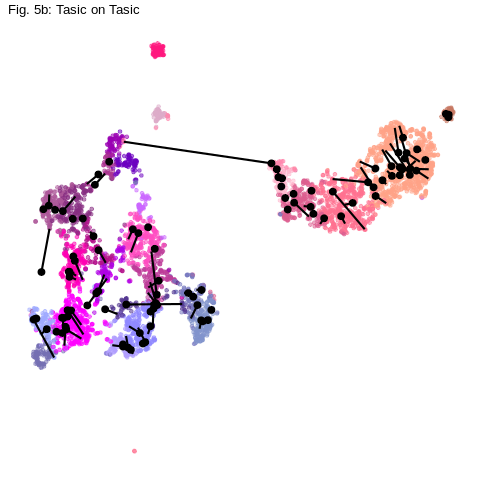

In [202]:
%%R
df <- data.frame("TSNE1" = reducedDim(filtered, "TSNE")[, 1],
                 "TSNE2" = reducedDim(filtered, "TSNE")[, 2],
                 "cluster" = colData(filtered)$cluster)
# Add 1 to cell numbers because Python 0-based indexing
tasic_sample <- df[tasic_on_tasic$cell_num + 1, c("TSNE1", "TSNE2")]
colnames(tasic_sample) <- c("TSNE1_old", "TSNE2_old")
tasic_sample <- cbind(tasic_sample, tasic_on_tasic)
tasic_subset <-df[important_clusters, ]

ggplot(data = tasic_subset) +
geom_point(mapping = aes(x = TSNE1, y = TSNE2, color = cluster, alpha = 0.1)) +
geom_point(data = tasic_sample, mapping=aes(x=TSNE1_new, y=TSNE2_new), size=3, colour="black") +
geom_segment(data = tasic_sample, mapping=aes(x=TSNE1_new, y=TSNE2_new, xend=TSNE1_old, yend=TSNE2_old), size=1) +
scale_color_manual(values = cluster_colors$cluster_color,
                   breaks = cluster_colors$cluster_label,
                   limits = cluster_colors$cluster_label) +
theme(legend.position = "none", axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank(), axis.text.x = element_blank(),
      axis.text.y = element_blank(), panel.background = element_rect(fill="white")) +
xlab(NULL) +
ylab(NULL) +
ggtitle("Fig. 5b: Tasic on Tasic")

In [200]:
%%R
ggsave("tasic_on_tasic.png", width=5, height=5)